# <font color='red'>Clustering on Movie_actor_network dataset</font>

# Objective

- Read graph from the given movie_actor_network.csv (note that the graph is bipartite graph.)

- Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph.

- Split the dense representation into actor nodes, movies nodes.

Task 1 : Apply clustering algorithm to group similar actors

Task 2 : Apply clustering algorithm to group similar movies

### Loading data

In [ ]:
#!pip install networkx==2.3

In [1]:
#importing libraries
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

C:\Users\natar\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\natar\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\natar\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor']) #reading data

In [3]:
edges = [tuple(x) for x in data.values.tolist()]     #getting edges

In [4]:
#creating bipartite graph from data
B = nx.Graph()      
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [5]:
A = (B.subgraph(c) for c in nx.connected_components(B))         #https://stackoverflow.com/a/63126712/17345549
A = list(A)[0]

In [6]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


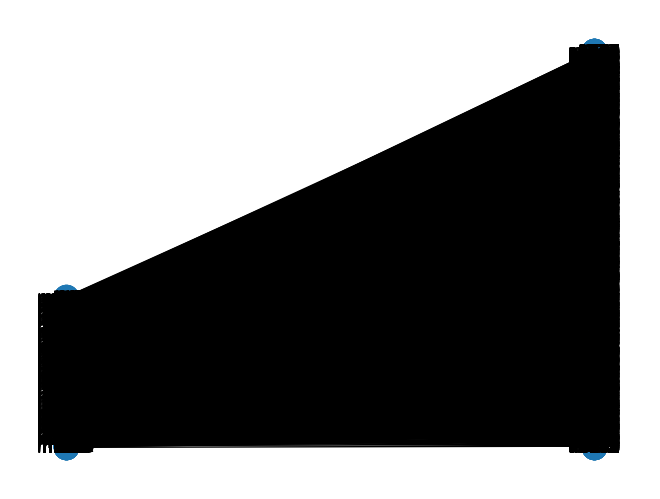

In [8]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [7]:
#count number of movie nodes and actor nodes
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [9]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [11]:
#using gensim library create w2v vector for each row of the walks data
from gensim.models import Word2Vec
model = Word2Vec(walks, vector_size=128, window=5)

In [12]:
model.wv.vectors.shape  # 128-dimensional vector for row in the walks data

(4703, 128)

In [13]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

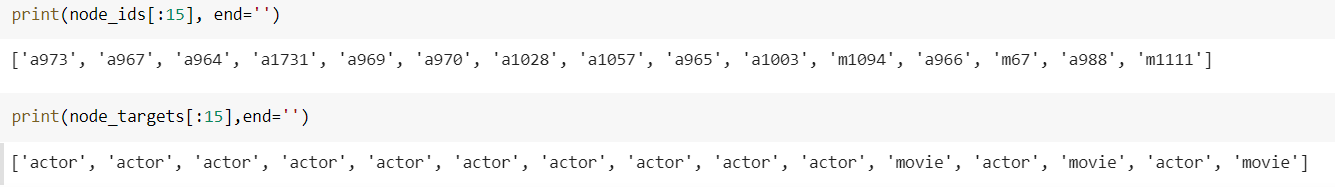

In [14]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes

    for i in range(len(node_ids)):
        if node_targets[i]=="actor":
            actor_nodes.append(node_ids[i])
            actor_embeddings.append(node_embeddings[i])
        elif node_targets[i]=="movie":
            movie_nodes.append(node_ids[i])
            movie_embeddings.append(node_embeddings[i])
        else:
            print("Unknown lable is present")
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [15]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings) #split the data

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [18]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    
    numerator=len(max(nx.connected_components(graph), key=len))#number of nodes in the largest connected component in the cluster
    denominator=graph.number_of_nodes()#total number of nodes in the given cluster 
    s=(numerator/denominator)
        
    cost1=s/number_of_clusters
    return cost1

In [19]:
#list(nx.clustering(graded_graph).keys())[0]

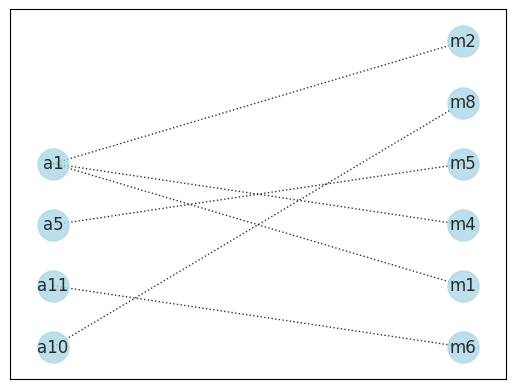

In [20]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [22]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''

    s=0
    movies_nodes = []
    actors_nodes= []
    for i in graph.nodes():
        if 'm' in i:
            movies_nodes.append(i)
        if 'a' in i:
            actors_nodes.append(i)
    numerator=sum(list(dict(graph.degree(actors_nodes)).values())) #sum of degrees of actor nodes in the graph with the actor nodes and its movie neighbouts in the given cluster
    denominator=len(movies_nodes)# number of unique movie nodes in the graph
    s=(numerator/denominator)
    cost2=s/number_of_clusters
    
    
    return cost2

<font color='blue'>Grouping similar actors</font>

In [24]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)


In [25]:
movie_embeddings=np.array(movie_embeddings)# converting list to array
actor_embeddings=np.array(actor_embeddings)

In [26]:
actor_embeddings.shape

(3411, 128)

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # you will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        You can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (You can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

# Finding best k

In [28]:
cost_list=[]       #to store the cost for each cluster size
cluster_number=[]  #to store the cluster number
for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:  #for various number of clusters
    km=KMeans(n_clusters=number_of_clusters)       
    km.fit(actor_embeddings)                   #fitting kmeans with the actor embedding for each different number of cluster
    actor_labels=km.labels_
    all_nodes_of_cluster=[]
    for i in range(number_of_clusters):   #for each cluster number
        nodes=[]
        for j in range(len(actor_labels)):#for the range of len of actor label
        
            if actor_labels[j]==i:     #if actor label is equal to cluster number, append that actor nodes to nodes list
                nodes.append(actor_nodes[j])     
        all_nodes_of_cluster.append(nodes)  #so each nodes is grouped to the respective cluster based on their labels
        
    Graph_list=[0]*number_of_clusters           #to store the graph that is created for each cluter
    for each_cluster in range(number_of_clusters):
        Graph_list[each_cluster]=nx.Graph()    #create graph for each cluster
        for each_node in all_nodes_of_cluster[each_cluster]:
            sub_graph=nx.ego_graph(A,each_node) #create ego graph for all nodes in one cluster each node at a time 
            Graph_list[each_cluster].add_nodes_from(sub_graph.nodes) # adding subgraph nodes 
            Graph_list[each_cluster].add_edges_from(sub_graph.edges()) # adding subgraph edges  
    
    cost1_sum=0
    cost2_sum=0
    for each_cluster in range(number_of_clusters):#for each number of cluster
        cost1_sum+=cost1(Graph_list[each_cluster],number_of_clusters) #create cost1 for  full graph
        cost2_sum+=cost2(Graph_list[each_cluster],number_of_clusters) ##create cost2 for full graph
    
    cost_list.append(cost1_sum*cost2_sum)
    cluster_number.append(number_of_clusters)
    #print(cost_list)
    
max_value = max(cost_list)                        #find maximum cost and its respective index     #reference taken from --- https://stackoverflow.com/a/6194580/17345549
max_index = cost_list.index(max_value)
best_actor_cluster=cluster_number[max_index]       #returning number of cluster which have maximum cost

In [29]:
best_actor_cluster

3

#### Cluster actors with best number of clusters value

In [30]:
km=KMeans(n_clusters=best_actor_cluster)   #fitting kmean with best k
km.fit(actor_embeddings)
actor_labels=km.labels_

In [33]:
actor_labels.shape  #verifying the shape of actor labels

(3411,)

In [34]:
actor_embeddings.shape

(3411, 128)

<font color='blue'>Displaying similar actor clusters</font>

In [35]:
from sklearn.manifold import TSNE    #dimentionlity reduction technique for visualization
transform = TSNE

trans = transform(n_components=2)
actor_embeddings_2d = trans.fit_transform(actor_embeddings)

In [36]:
actor_embeddings_2d[0]

array([-27.895176, -55.951683], dtype=float32)

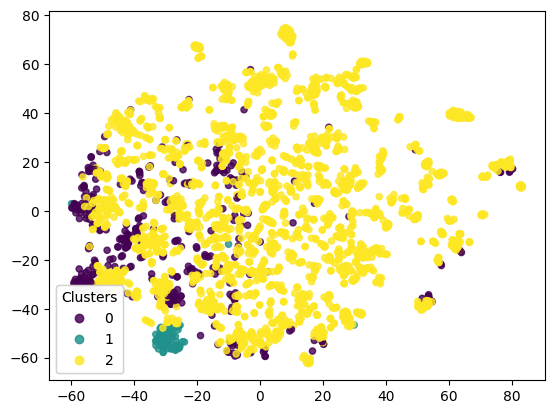

In [37]:
import numpy as np

label_map = { l: i for i, l in enumerate(np.unique(actor_labels))}   #mapping labels
node_colours = [ label_map[target] for target in actor_labels]      #each label in the actor label give them a unique value based on their cluster they belong

fig, ax = plt.subplots()
scatter = ax.scatter(actor_embeddings_2d[:,0], actor_embeddings_2d[:,1], c=node_colours,s = 20,alpha=0.8)  #plotting scatter plot

# produce a legend with the unique colors from the scatter      https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
legend1 = ax.legend(*scatter.legend_elements(),loc="lower left", title="Clusters")
ax.add_artist(legend1)
plt.show()

<font color='blue'>Grouping similar movies</font>

In [38]:
def cost2_movie(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''

    s=0
    movies_nodes = []
    actors_nodes= []
    for i in graph.nodes():
        if 'm' in i:
            movies_nodes.append(i)
        if 'a' in i:
            actors_nodes.append(i)
    numerator=sum(list(dict(graph.degree(movies_nodes)).values())) #sum of degrees of movie nodes in the graph with the actor nodes and its movie neighbouts in the given cluster
    denominator=len(actors_nodes)   # number of unique actor nodes in the graph
    s=(numerator/denominator)
    
    cost2=s/number_of_clusters
    return cost2

In [42]:
cost_list=[]       #to store the cost for each cluster size
cluster_number=[]  #to store the cluster number
for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:  #for various number of clusters
    km=KMeans(n_clusters=number_of_clusters)       
    km.fit(movie_embeddings)                   #fitting kmeans with the movie embedding for each different number of cluster
    movie_labels=km.labels_
    all_nodes_of_cluster=[]
    for i in range(number_of_clusters):   #for each cluster number
        nodes=[]
        for j in range(len(movie_labels)):#for the range of len of movie label
        
            if movie_labels[j]==i:     #if movie label is equal to cluster number, append that movie nodes to nodes list
                nodes.append(movie_nodes[j])     
        all_nodes_of_cluster.append(nodes)  #so each nodes is grouped to the respective cluster based on their labels
        
    Graph_list=[0]*number_of_clusters           #to store the graph that is created for each cluter
    for each_cluster in range(number_of_clusters):
        Graph_list[each_cluster]=nx.Graph()    #create graph for each cluster
        for each_node in all_nodes_of_cluster[each_cluster]:
            sub_graph=nx.ego_graph(A,each_node) #create ego graph for all nodes in one cluster each node at a time 
            Graph_list[each_cluster].add_nodes_from(sub_graph.nodes) # adding subgraph nodes 
            Graph_list[each_cluster].add_edges_from(sub_graph.edges()) # adding subgraph edges  
    
    cost1_sum=0
    cost2_sum=0
    for each_cluster in range(number_of_clusters):#for each number of cluster
        cost1_sum+=cost1(Graph_list[each_cluster],number_of_clusters) #create cost1 for  full graph
        cost2_sum+=cost2_movie(Graph_list[each_cluster],number_of_clusters) #create "cost2_movie" for full graph
    
    cost_list.append(cost1_sum*cost2_sum)
    cluster_number.append(number_of_clusters)

       
max_value = max(cost_list)                        #find maximum cost and its respective index     #reference taken from --- https://stackoverflow.com/a/6194580/17345549
max_index = cost_list.index(max_value)
best_movie_cluster=cluster_number[max_index]       #returning number of cluster which have maximum cost

In [43]:
best_movie_cluster

3

In [52]:
km=KMeans(n_clusters=best_movie_cluster)
km.fit(movie_embeddings)
movie_labels=km.labels_

<font color='blue'>Displaying similar movie clusters</font>

In [56]:
from sklearn.manifold import TSNE #dimentionlity reduction technique for visualization
transform = TSNE 

trans = transform(n_components=2)
movie_embeddings_2d = trans.fit_transform(movie_embeddings)

In [57]:
movie_embeddings_2d[0]

array([30.361633, 19.540161], dtype=float32)

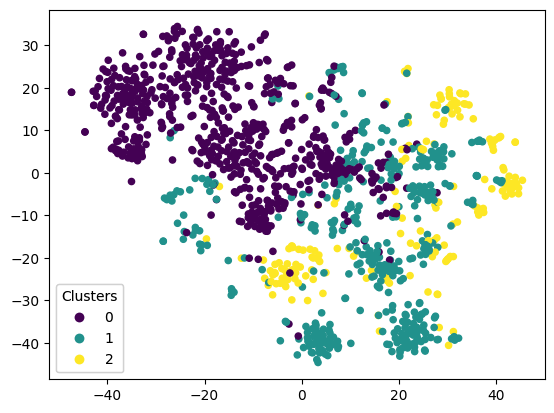

In [58]:

label_map = { l: i for i, l in enumerate(np.unique(movie_labels))} #mapping labels
node_colours = [ label_map[target] for target in movie_labels] #each label in the movie label give them a unique value based on their cluster they belong

fig, ax = plt.subplots()
scatter = ax.scatter(movie_embeddings_2d[:,0], movie_embeddings_2d[:,1],s = 20, c=node_colours) #plotting scatter plot

# produce a legend with the unique colors from the scatter      https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Clusters")
ax.add_artist(legend1)
plt.show()